## Install Dependencies and Load Datasets

In [1]:
!pip install optuna

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import average_precision_score, roc_auc_score
import optuna
from sklearn.inspection import permutation_importance

In [3]:
# Using CSV files with 82k rows
txn_file_id = "1iG3mFohP7A4NqjbVDHV-B917uecBlyz5"
txn_url = f"https://drive.google.com/uc?id={txn_file_id}"
txn_file = gdown.download(txn_url, quiet=False)
txn_df = pd.read_csv(txn_file)
txn_df.head()

Downloading...
From: https://drive.google.com/uc?id=1iG3mFohP7A4NqjbVDHV-B917uecBlyz5
To: C:\Users\User\OneDrive\Documents\BT4012 project\full_df.csv
100%|████████████████████████████████████████████████████████████████████████████████| 29.5M/29.5M [00:29<00:00, 986kB/s]


,tx_hash,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,in_malicious,out_malicious,...,activity_span_days,cp_hhi_out,cp_hhi_in,peel_len,peel_ratio,pagerank,betweenness_centrality,closeness_centrality,katz_centrality,local_clustering
0,56a96d9841d22764287c9a37cedf97c47678690c2507e0...,5,2,188.74,188.74,377.48,37.748000,94.37,0,0,...,0.000000,10000.0,0.000000,1,3.740000e+08,0.000006,0.0,0.000000,0.001538,0.0
1,93d9e131c856061a11adc1054eaaf7502d147eb9e754fd...,0,1,0.00,50.00,50.00,0.000000,50.00,0,0,...,0.000000,10000.0,0.000000,2,5.000000e+09,0.000006,0.0,0.000000,0.001538,0.0
2,52093f1f0c88f21966817bc6593fcf3e2cb0c314099182...,104,1,5199.00,5199.00,10398.00,49.990385,5199.00,1,0,...,23.596343,10000.0,96.153846,1,1.000000e+00,0.000537,0.0,0.001268,0.017549,0.0
3,31d0381a230ef3c092fac8dd415cb0e02cf4f4546b03de...,0,1,0.00,50.00,50.00,0.000000,50.00,0,0,...,0.000000,10000.0,0.000000,2,5.000000e+09,0.000006,0.0,0.000000,0.001538,0.0
4,ca485d7d88cd8f82730c1530f272edf95e140d66b29f0c...,0,1,0.00,50.00,50.00,0.000000,50.00,0,0,...,0.000000,10000.0,0.000000,2,5.000000e+09,0.000006,0.0,0.000000,0.001538,0.0


## Splitting of Datasets

In [4]:
malicious_set = txn_df[txn_df['is_malicious'] == 1]
non_malicious_set = txn_df[txn_df['is_malicious'] == 0]

X_train_non_malicious, X_temp_non_malicious, y_train_non_malicious, y_temp_non_malicious = train_test_split(
    non_malicious_set.drop(columns=['is_malicious']),
    non_malicious_set['is_malicious'],
    test_size=0.4,
    random_state=42
)

X_val_non_malicious, X_test_non_malicious, y_val_non_malicious, y_test_non_malicious = train_test_split(
    X_temp_non_malicious,
    y_temp_non_malicious,
    test_size=0.5,
    random_state=42
)

# Split malicious data equally into validation and test sets
X_val_malicious, X_test_malicious, y_val_malicious, y_test_malicious = train_test_split(
    malicious_set.drop(columns=['is_malicious']),
    malicious_set['is_malicious'],
    test_size=0.5,
    random_state=42
)

# Combine non-malicious and malicious data for validation and test sets
X_val = pd.concat([X_val_non_malicious, X_val_malicious])
y_val = pd.concat([y_val_non_malicious, y_val_malicious])

X_test = pd.concat([X_test_non_malicious, X_test_malicious])
y_test = pd.concat([y_test_non_malicious, y_test_malicious])

# Training set consists only of non-malicious transactions
X_train = X_train_non_malicious
y_train = y_train_non_malicious

print("\nMalicious transactions in validation set:", y_val.sum())
print("Malicious transactions in test set:", y_test.sum())
print("Malicious transactions in training set:", y_train.sum())


Malicious transactions in validation set: 23
Malicious transactions in test set: 24
Malicious transactions in training set: 0


## Feature Engineering

In [5]:
scaler = RobustScaler()
columns_to_drop = ['tx_hash', 'first_seen', 'last_seen', 'in_malicious', 'out_malicious', 'out_and_tx_malicious', 'all_malicious']

def feature_engineering_train(df):
  df = df.copy()
  features_to_log_scale = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc', 'degree_sum',
                          'degree_diff', 'in_out_degree_ratio', 'in_out_btc_ratio', 'value_per_in_edge', 'value_per_out_edge',
                          'value_per_all_edges', 'tx_count', 'activity_span_seconds', 'activity_span_days', 'peel_len', 'peel_ratio',
                          'pagerank', 'betweenness_centrality', 'closeness_centrality', 'katz_centrality', 'local_clustering']
  features_to_normalize = ['cp_hhi_out', 'cp_hhi_in']

  for col in features_to_log_scale:
    df[col + '_log'] = np.log1p(df[col])

  features_to_normalize.extend([col + '_log' for col in features_to_log_scale])
  df[[c + '_norm' for c in features_to_normalize]] = scaler.fit_transform(df[features_to_normalize])

  df.drop(columns=features_to_normalize + features_to_log_scale + columns_to_drop, inplace=True)
  return df

def feature_engineering_unseen(df):
  df = df.copy()
  features_to_log_scale = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc', 'degree_sum',
                          'degree_diff', 'in_out_degree_ratio', 'in_out_btc_ratio', 'value_per_in_edge', 'value_per_out_edge',
                          'value_per_all_edges', 'tx_count', 'activity_span_seconds', 'activity_span_days', 'peel_len', 'peel_ratio',
                          'pagerank', 'betweenness_centrality', 'closeness_centrality', 'katz_centrality', 'local_clustering']
  features_to_normalize = ['cp_hhi_out', 'cp_hhi_in']

  for col in features_to_log_scale:
    df[col + '_log'] = np.log1p(df[col])

  features_to_normalize.extend([col + '_log' for col in features_to_log_scale])
  df[[c + '_norm' for c in features_to_normalize]] = scaler.transform(df[features_to_normalize])

  df.drop(columns=features_to_normalize + features_to_log_scale + columns_to_drop, inplace=True, errors='ignore')
  return df

X_train = feature_engineering_train(X_train)
X_val = feature_engineering_unseen(X_val)
X_test = feature_engineering_unseen(X_test)

X_train.head()

,is_high_indegree,is_high_outdegree,is_high_total_btc,cp_hhi_out_norm,cp_hhi_in_norm,indegree_log_norm,outdegree_log_norm,in_btc_log_norm,out_btc_log_norm,total_btc_log_norm,...,tx_count_log_norm,activity_span_seconds_log_norm,activity_span_days_log_norm,peel_len_log_norm,peel_ratio_log_norm,pagerank_log_norm,betweenness_centrality_log_norm,closeness_centrality_log_norm,katz_centrality_log_norm,local_clustering_log_norm
71584,0,0,0,0.750000,-0.071429,-0.251930,-0.405465,0.000760,-0.158323,-0.123488,...,-0.323657,0.000000,0.000000,1.0,1.383505,-0.042143,0.0,-0.222227,-0.340185,0.0
4874,0,0,0,-0.250000,0.095238,0.682606,-0.405465,0.461751,0.392328,0.370423,...,0.676343,1.154313,2.403178,0.0,0.000000,8.509056,0.0,3.921477,2.333014,0.0
12407,0,0,0,-0.227273,-0.071429,-0.251930,3.835862,0.857308,0.715676,0.704975,...,2.161662,0.000000,0.000000,0.0,0.000000,-0.042143,0.0,-0.222227,-0.340185,0.0
18881,0,0,1,0.750000,-0.071429,-0.251930,0.000000,2.152248,2.058681,1.905844,...,-0.323657,0.000000,0.000000,1.0,1.891976,-0.042143,0.0,-0.222227,-0.340185,0.0
24909,0,0,0,-0.083333,0.928571,0.178747,2.233592,0.779708,0.703176,0.662218,...,0.782933,0.697764,0.046276,0.0,0.000000,0.278502,0.0,0.000000,0.000000,0.0


## Hyperparameter Tuning of Isolation Forest Model

In [6]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_samples = trial.suggest_float('max_samples', 0.1, 1.0)
    contamination = trial.suggest_float('contamination', 0.0, 0.5)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    model = IsolationForest(n_estimators=n_estimators,
                            max_samples=max_samples,
                            contamination=contamination,
                            max_features=max_features,
                            random_state=42)

    model.fit(X_train)
    y_scores_val = model.decision_function(X_val)
    auc_pr_val = average_precision_score(y_val, -y_scores_val)

    return auc_pr_val

# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # You can adjust the number of trials

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best AUC-PR on Validation Set:", best_score)

[I 2025-11-21 23:13:18,732] A new study created in memory with name: no-name-7686dadb-2e84-4032-acdb-79c0f26dc763
[I 2025-11-21 23:13:28,141] Trial 0 finished with value: 0.1717881914291189 and parameters: {'n_estimators': 346, 'max_samples': 0.469702644487329, 'contamination': 0.17409384720806376, 'max_features': 0.18470552700340587}. Best is trial 0 with value: 0.1717881914291189.
[I 2025-11-21 23:13:37,801] Trial 1 finished with value: 0.17493686983503123 and parameters: {'n_estimators': 390, 'max_samples': 0.3776602224706199, 'contamination': 0.23015434342409186, 'max_features': 0.49036073475270014}. Best is trial 1 with value: 0.17493686983503123.
[I 2025-11-21 23:13:51,150] Trial 2 finished with value: 0.1492753775445865 and parameters: {'n_estimators': 369, 'max_samples': 0.6583758303722038, 'contamination': 0.3655808770510862, 'max_features': 0.5547726345994072}. Best is trial 1 with value: 0.17493686983503123.
[I 2025-11-21 23:14:07,669] Trial 3 finished with value: 0.14939664

Best Hyperparameters: {'n_estimators': 366, 'max_samples': 0.4642672046056142, 'contamination': 0.16374712538977415, 'max_features': 0.6754206240212405}
Best AUC-PR on Validation Set: 0.18291734806926585


## Predictions on Test Set

In [7]:
best_model = IsolationForest(**best_params, random_state=42)
best_model.fit(X_train)

y_scores_test_tuned = best_model.decision_function(X_test)

# Calculate AUC-PR for the tuned model
auc_pr_tuned = average_precision_score(y_test, -y_scores_test_tuned)
print(f"AUC-PR on Test Set (Tuned Model): {auc_pr_tuned:.4f}")

# Calculate ROC AUC for the tuned model
roc_auc_tuned = roc_auc_score(y_test, -y_scores_test_tuned)
print(f"ROC AUC on Test Set (Tuned Model): {roc_auc_tuned:.4f}")

k = y_test.sum() # k is the number of actual malicious transactions

# Combine scores with true labels and sort by score (higher score is more anomalous)
df_results = pd.DataFrame({'true_label': y_test, 'anomaly_score': -y_scores_test_tuned})
df_results = df_results.sort_values(by='anomaly_score', ascending=False).reset_index(drop=True)

# Top k predictions
top_k_predictions = df_results.head(k)

# Calculate Precision@k
tp_k = top_k_predictions['true_label'].sum()
precision_at_k = tp_k / k

# Calculate Recall@k
actual_malicious = y_test.sum()
recall_at_k = tp_k / actual_malicious if actual_malicious > 0 else 0

print(f"\nPrecision@{k}: {precision_at_k:.4f}")
print(f"Recall@{k}: {recall_at_k:.4f}")

AUC-PR on Test Set (Tuned Model): 0.0935
ROC AUC on Test Set (Tuned Model): 0.8629

Precision@24: 0.0833
Recall@24: 0.0833


## Feature Importance

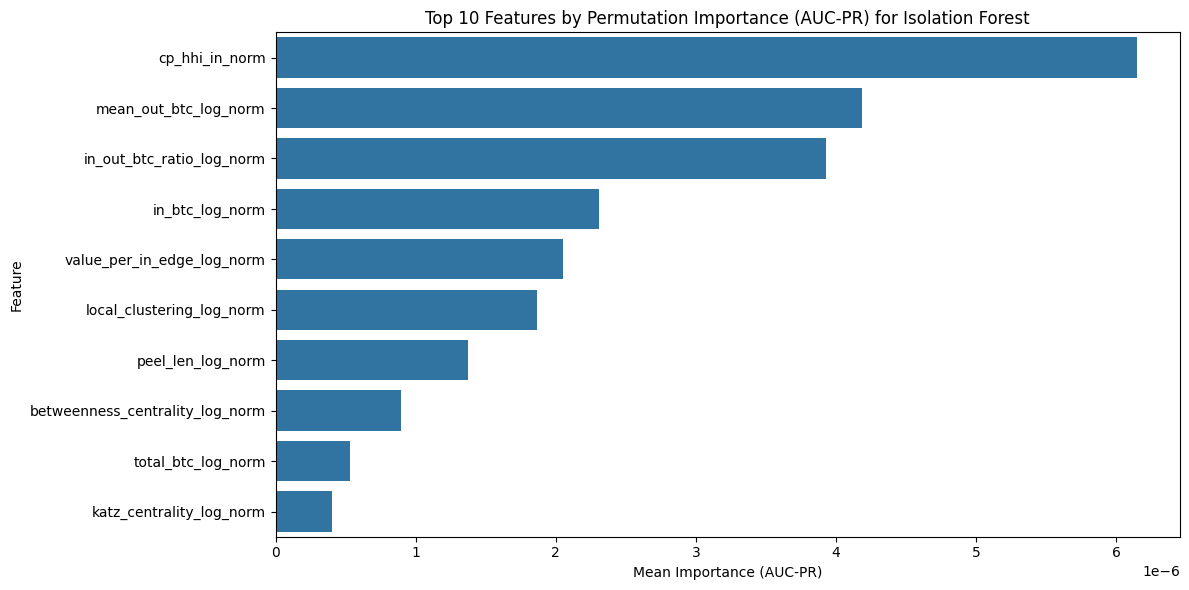

In [8]:
X_test_importance = X_test.copy()
y_test_importance = y_test.copy()

result = permutation_importance(
    best_model,
    X_test_importance,
    y_test_importance,
    scoring='average_precision',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

feature_importances = pd.DataFrame({
    'feature': X_test_importance.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
})

# Sort by importance and display top 10
feature_importances = feature_importances.sort_values(by='importance_mean', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='importance_mean', y='feature', data=feature_importances.head(10))
plt.title('Top 10 Features by Permutation Importance (AUC-PR) for Isolation Forest')
plt.xlabel('Mean Importance (AUC-PR)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()